In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sp-model-12k/sp_model (9).model
/kaggle/input/sp-model-12k/sp_model (9).vocab
/kaggle/input/sp-model-12k-without-filterwords/sp_model (10).model
/kaggle/input/sp-model-12k-without-filterwords/sp_model (10).vocab
/kaggle/input/tweet-sentiment-extraction/sample_submission.csv
/kaggle/input/tweet-sentiment-extraction/train.csv
/kaggle/input/tweet-sentiment-extraction/test.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [3]:
# install required packages
!pip install nltk sentencepiece datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [5]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import sentencepiece as spm
import json
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch import nn
import os
import numpy as np
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from collections import defaultdict
import nltk
from argparse import Namespace
import gc
from datasets import load_dataset
import re
import string
from nltk.corpus import stopwords, wordnet
import emoji
from nltk import pos_tag
from collections import Counter

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
training_args = {
    "batch_size": 64,
    'eval_steps':500,
    "max_steps": 40000,
    "warmup_steps": 4000,
    "learning_rate": 1e-4,
    "lr_decay_ratio": 0.01,
    'weight_decay': 1e-5,
    'onnx': False,
    'run_name': 'sentiement_transformer',
    "device": 'cuda' if torch.cuda.is_available() else 'cpu',
    "output_path": "/kaggle/working/",
    "batch_first": True,
    'seed':42,
    "cpu_num_workers": os.cpu_count(),
    'pin_memory': True,
    'torch_compile':False,
    'precision': 'high',
    'save_models_dir': "/kaggle/working/",
    'resume_from_checkpoint': '/kaggle/input/bot-dataset/sentiement_transformer_checkpoint.pt'
}


tokenizer_args = {
    "model_prefix": "sp_model",
    "model_type": "bpe",
    "vocab_size": 12000, 
    "normalization_rule_name": "identity",
    "remove_extra_whitespaces": True,
    "input_sentence_size": 200000000,
    "max_sentence_length": 4192,
    "seed_sentencepiece_size": 1000000,
    "shuffle_input_sentence": True,
    "character_coverage": 0.99995,
    "byte_fallback": True,
    "split_digits": True,
    "split_by_unicode_script": True,
    "split_by_whitespace": True,
    "split_by_number": True,
    "max_sentencepiece_length": 16,
    "add_dummy_prefix": True,
    "allow_whitespace_only_pieces": False,
    "unk_id": 1,
    "bos_id": 2,
    "eos_id": 3,
    "pad_id": 0,
    "num_threads": 2,
    "user_defined_symbols": "<cls>"
}


model_args = {
    "dim_embed": 256,
    "dim_model": 256,
    "dim_feedforward": 1024,
    "num_layers": 16,
    "dropout": 0.1,
    "max_len": 512,
}

id_classes = {0:'Neutral',1:'Positive', 2:'Negative'}

training_args = Namespace(**training_args)
tokenizer_args = Namespace(**tokenizer_args)
model_args = Namespace(**model_args)

In [7]:
!sudo unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [8]:
names = ['id', 'company', 'label', 'sentence']
test_set = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv', names=names[2:], usecols= [2,3])
train_set = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', names=names[2:], usecols=[2,3])
train_set.shape, test_set.shape

((74682, 2), (1000, 2))

In [9]:
train_set['label'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [10]:
train_set.iloc[179]['sentence']

'Platinum is the best loot the'

In [11]:
def overview(data):
    """Prints basic information and statistics of the DataFrame."""
    
    print("Dataset Overview:")
    print(data.info())
    print('-' * 50)

    eda_overview = pd.DataFrame({
        "Metric": ["Rows", "Columns", "Missing Values", "Duplicate Rows"],
        "Value": [
            len(data),
            len(data.columns),
            data.isnull().sum().sum(),
            data.duplicated().sum()
        ]
    })
    print(eda_overview)
    print('-' * 100, end='\n\n')
overview(train_set)
overview(test_set)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     74682 non-null  object
 1   sentence  73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB
None
--------------------------------------------------
           Metric  Value
0            Rows  74682
1         Columns      2
2  Missing Values    686
3  Duplicate Rows   4909
----------------------------------------------------------------------------------------------------

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     1000 non-null   object
 1   sentence  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB
None
--------------------------------------------------
           Metric  Value
0 

In [12]:
train_set.dropna(inplace=True)
train_set.drop_duplicates(inplace=True)

test_set.dropna(inplace=True)
test_set.drop_duplicates(inplace=True)
train_set.shape, test_set.shape

((69769, 2), (999, 2))

In [13]:
# Download the stopwords list if you haven't already
nltk.download('stopwords')

# Load the default stopwords list
default_stopwords = set(stopwords.words('english'))

# Define the negation words you want to remove
negation_words = {'not', 'no', 'nor', 'neither', 'never', 'none'}

# Remove the negation words from the stopwords list
filtered_stopwords = [word for word in default_stopwords if word not in negation_words]

# Alternatively, you can use set operations for a more concise approach
filtered_stopwords = default_stopwords - negation_words

# Convert the set back to a list if needed
filtered_stopwords = list(filtered_stopwords)

# Print the filtered stopwords list
# print(filtered_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Replacement dictionary
replacements = {
    "won't": "would not",
    "im": "I am",
    "Im": "I am",
    "can't": "can not",
    "cannot": "can not",
    
    "don't": "do not",
    "shouldn't": "should not",
    "needn't": "need not",
    "hasn't": "has not",
    "haven't": "have not",
    "weren't": "were not",
    "mightn't": "might not",
    "didn't": "did not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am",
    "unk": " "
}

# Function to replace matched patterns
def replace_match(match):
    return replacements.get(match.group(0), match.group(0))

In [15]:
def get_wordnet_pos(tag):
    """Map NLTK POS tags to WordNet POS tags."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
filter_words = ['amazon', 'apex', 'assassin', 'battlefield', 'bfbd', 'bioshock', 'borderland', 
                    'borderlands', 'call', 'com', 'creed', 'csgo', 'dead', 'doom', 'duty', 'facebook', 
                    'fifa', 'fortnite', 'game', 'google', 'gta', 'halo', 'hearts', 'instagram', 
                    'johnson', 'kingdom', 'league', 'legends', 'mario', 'microsoft', 'minecraft', 
                    'nintendo', 'nividia', 'overwatch', 'pic', 'pokemon', 'pubg', 'red', 'reddit', 
                    'redemption', 'rocket', 'super', 'tv', 'twitch', 'twitter', 'verizon', 'xbox', 'youtube', 'play', 'make']

pattern = r"(won\'t|im|Im|can\'t|don\'t|shouldn\'t|needn\'t|hasn\'t|haven\'t|weren\'t|mightn\'t|didn\'t|n\'t|\'re|\'s|\'d|\'ll|\'t|\'ve|\'m|unk)"
def parse_function(text, cls, language='english'):
    text = str(text)
    # Combined regular expression
    text = re.sub(pattern, replace_match, text)
    # for html tags 
    html_tags_regex = re.compile(r'<[^>]+>',flags=re.IGNORECASE)
    
    # for stopwords
    nltk.download('stopwords', quiet=True)
    stopwords_regex = re.compile(r'\b(' + r'|'.join(filtered_stopwords) + r')\b\s*',flags=re.IGNORECASE)
   
    # for punctuations
    punctuations_regex = re.compile(r'[^a-z0-9\s]+',flags=re.IGNORECASE)
    # for words that contains numbers like f4g
    words_contains_numbers_regex = re.compile(r'\w*\d+\w*',flags=re.IGNORECASE)
    # for urls and links
    urls_regex = re.compile(r'https?:\/\/\s+|www\.\s+',flags=re.IGNORECASE)
   
    # Filter out words in the filter_words list
    filter_words_regex = re.compile(r'\b(' + r'|'.join(filter_words) + r')\b', flags=re.IGNORECASE)
    # Remove 1-2 character words
    trash_word_regex = re.compile(r'\b\w{1,2}\b') # except word 'no'
    
    # for multiple spaces and newlines
    multi_space_regex = re.compile(r'\n+|\s+') 
    # Remove mentions
    mentions_regex = re.compile(r'@[a-zA-Z0-9_]+') 
    # Remove special characters
    special_ch_regex = re.compile(r'\W') 
    # Remove after . 
    after_dot_regex = re.compile(r'\..*') 
    
    text = emoji.demojize(text)  # Convert emojis to text
    text = html_tags_regex.sub(' ', text)
    # text = after_dot_regex.sub(' ', text)
    text = punctuations_regex.sub(' ', text)
    text = words_contains_numbers_regex.sub(' ', text)
    text = urls_regex.sub(' ', text)
    text = mentions_regex.sub(' ',text)
    text = special_ch_regex.sub(' ',text) 
    text = multi_space_regex.sub(' ', text)
    text = text.strip()

    # text = text.capitalize()
    # Apply POS tagging and filter tokens
    text = text.split()  # i am yousef => [i, am , yousef]
    tagged_tokens = pos_tag(text)
    # print(tagged_tokens)
    filtered_words = [
       word.lower() for word, tag in tagged_tokens
        # if get_wordnet_pos(tag) in [wordnet.ADJ, wordnet.VERB, wordnet.ADV] # Filter only adjectives, verbs, and adverbs
        # or word in negation_words
    ]
    text = ' '.join(filtered_words) # i am yousef 
    text = filter_words_regex.sub(' ',text)
    text = stopwords_regex.sub(' ', text)
    text = trash_word_regex.sub(' ',text)
    text = multi_space_regex.sub(' ', text)
    text = text.lower()
    text = text.strip()

  
    label=0
    if cls.lower() == 'positive':
        label = 1
    elif cls.lower() == 'negative':
        label = 2

    return text, label


## function to map preprocess_function for al rows for a dataframe
def mymap(df_reviews, lang='english'):
    prepro_reviews = {'reviews':[], 'labels':[]}

    for cls, text in df_reviews.values:
        review, label = parse_function(text, cls)
        prepro_reviews['reviews'].append(review)
        prepro_reviews['labels'].append(label)

    return prepro_reviews

In [17]:
# Calling preprocess_function on reviews
df_prepro_reviews_train = pd.DataFrame(mymap(train_set))
df_prepro_reviews_test = pd.DataFrame(mymap(test_set))

df_prepro_reviews_train = df_prepro_reviews_train[df_prepro_reviews_train['reviews'] != '']  # Drop empty strings
df_prepro_reviews_test = df_prepro_reviews_test[df_prepro_reviews_test['reviews'] != '']  # Drop empty strings

In [18]:
# df_prepro_reviews_train = df_prepro_reviews_train[df_prepro_reviews_train['reviews'].apply(lambda x: len(x) > 0)]
# df_prepro_reviews_test = df_prepro_reviews_test[df_prepro_reviews_test['reviews'].apply(lambda x: len(x) > 0)]

In [19]:
df_prepro_reviews_train['reviews']

0                                           getting murder
1                                      coming borders kill
2                                             getting kill
3                                            coming murder
4                                           getting murder
                               ...                        
69764    realized windows partition mac like years behi...
69765    realized mac window partition years behind nvi...
69766    realized windows partition mac years behind nv...
69767    realized windows partition mac like years behi...
69768    like windows partition mac like years behind d...
Name: reviews, Length: 69022, dtype: object

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


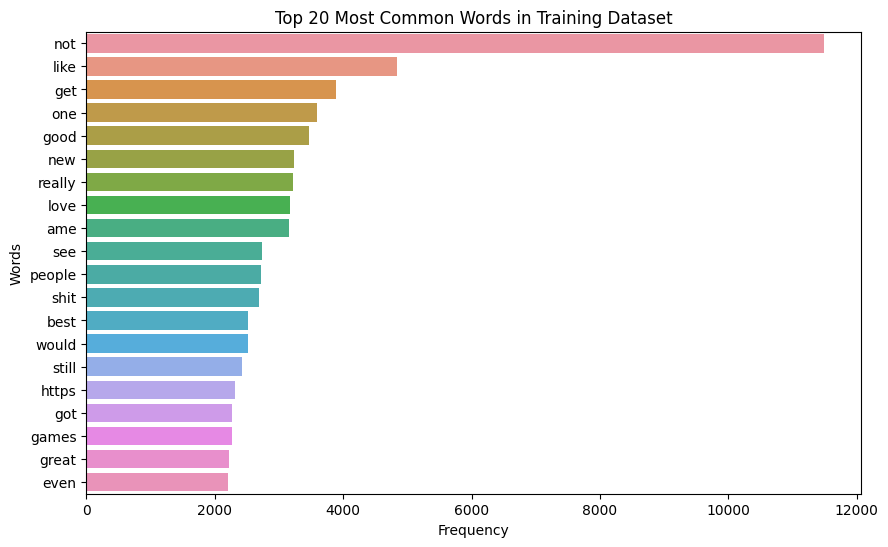

In [20]:
def common_words(data):

    all_words = data['reviews'].str.split().explode()
    word_freq = Counter(all_words)
    common_words = word_freq.most_common(20)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), orient='h')
    plt.title("Top 20 Most Common Words in Training Dataset")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()
common_words(df_prepro_reviews_train)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


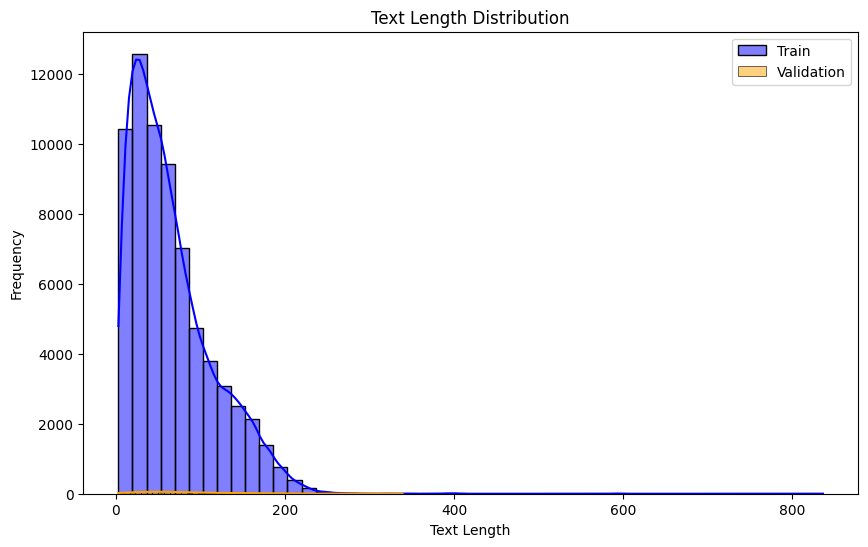

In [21]:
def text_length_distribution(data, data_test):

    data['text_length'] = data['reviews'].str.len()
    data_test['text_length'] = data_test['reviews'].str.len()

    # Plotting text length distribution
    # Visualize text lengths for both train and validation datasets
    plt.figure(figsize=(10, 6))
    sns.histplot(data['text_length'], bins=50, kde=True, color='blue', label='Train')
    sns.histplot(data_test['text_length'], bins=50, kde=True, color='orange', label='Validation')
    plt.title("Text Length Distribution")
    plt.xlabel("Text Length")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
text_length_distribution(df_prepro_reviews_train,df_prepro_reviews_test)

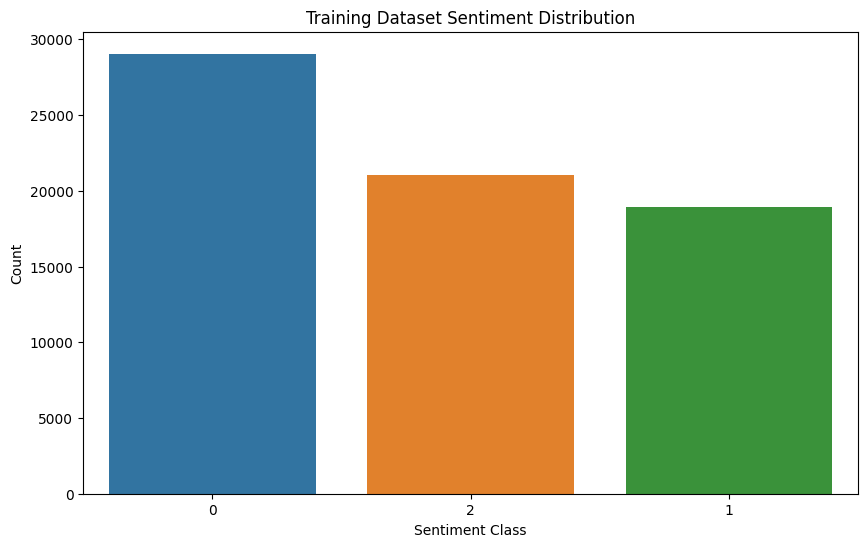

In [22]:
def classes_distribution(data):

    plt.figure(figsize=(10, 6))
    sns.countplot(x='labels', data=data, order=data['labels'].value_counts().index)
    plt.title("Training Dataset Sentiment Distribution")
    plt.xlabel("Sentiment Class")
    plt.ylabel("Count")
    plt.show()
classes_distribution(df_prepro_reviews_train)

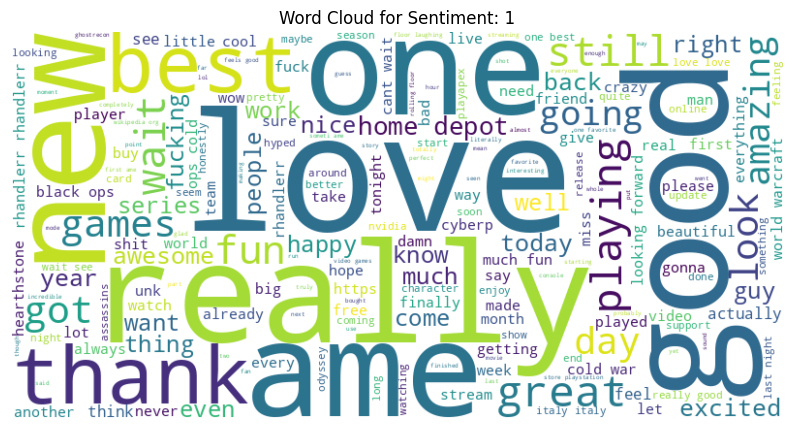

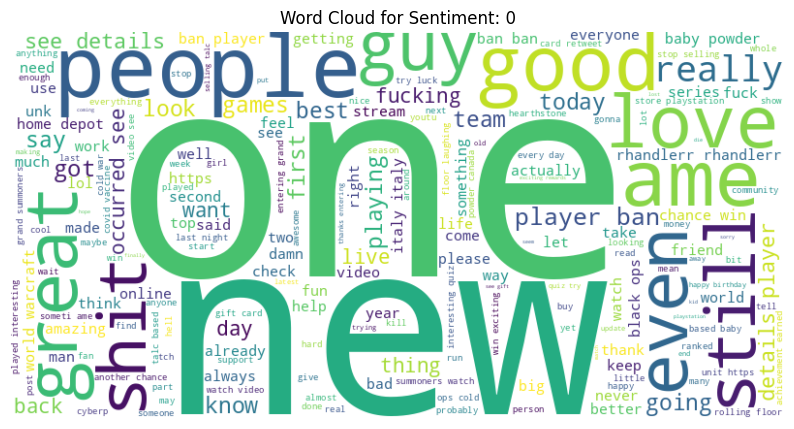

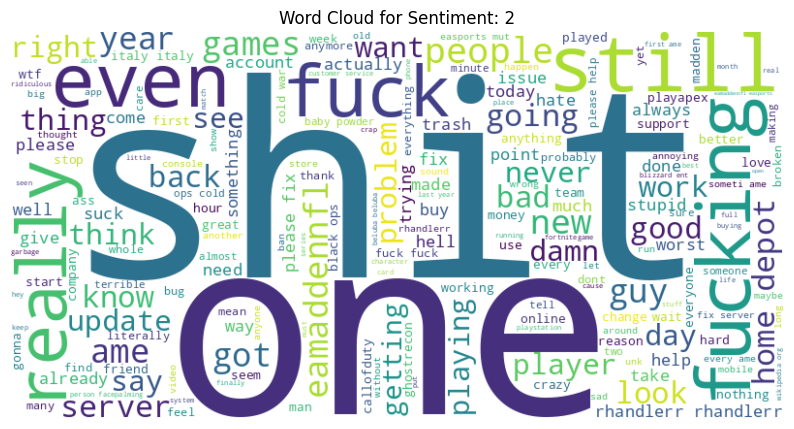

In [23]:
from wordcloud import WordCloud
def word_cloud(data):

    sentiments = data['labels'].unique()
    for sentiment in sentiments:
        sentiment_text = data[data['labels'] == sentiment]['reviews'].str.cat(sep=' ')
        sentiment_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)
        plt.figure(figsize=(10, 6))
        plt.imshow(sentiment_wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Word Cloud for Sentiment: {sentiment}")
        plt.show()
word_cloud(df_prepro_reviews_train)

In [24]:
def train_tokenizer(dataframe:pd.DataFrame, tokenizer_params:dict, train_on_columns:list, tokenizer_path):
    print("Starting Tokenizer Train...")

    # dataframe = pd.read_csv(train_csv_path)[train_on_columns]
    sentences = []
    for col in train_on_columns:
        sentences = sentences + dataframe[col].to_list()
    tokenizer_params.model_prefix = os.path.join(tokenizer_path, tokenizer_params.model_prefix)
    spm.SentencePieceTrainer.train(sentence_iterator=iter(sentences), **vars(tokenizer_params))

    print(f"{tokenizer_params.model_prefix} Done")
    statics_dict = {col: len(dataframe[col]) for col in train_on_columns}
    print("Tokenizer Train Done.")
    print(f"Trained on {statics_dict} sentences")  


## Tokenizer
class Callable_tokenizer():
    def __init__(self, tokenizer_path):
        self.path = tokenizer_path
        self.tokenizer = spm.SentencePieceProcessor()
        self.tokenizer.load(tokenizer_path)
    def __call__(self, text):
        return self.tokenizer.Encode(text)

    def get_tokenId(self, token_name):
        return self.tokenizer.piece_to_id(token_name)

    def get_tokenName(self, id):
        return self.tokenizer.id_to_piece(id)

    def decode(self, tokens_list):
        return self.tokenizer.Decode(tokens_list)

    def __len__(self):
        return len(self.tokenizer)

    def input_tokenization(self, instruction, text):
        return  self(instruction) + [self.get_tokenId('<sep>')] + self(text)

    def output_tokenization(self, text):
        return [self.get_tokenId('<s>')] + self(text) + [self.get_tokenId('</s>')]

# train_tokenizer(df_prepro_reviews_train, tokenizer_args, ['reviews'], training_args.output_path)

In [25]:
# tokenizer = Callable_tokenizer(tokenizer_args.model_prefix + '.model')
tokenizer = Callable_tokenizer('/kaggle/input/sp-model-12k/sp_model (9).model')


In [26]:
# the vocabulary size
vocab_size = len(tokenizer)
vocab_size

12000

In [27]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, input_texts, sents_texts, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.cls = self.tokenizer.get_tokenId('<cls>')
        # Apply tokenization and truncation in __init__
        self.reviews_ids = [
            [self.cls] + tokenizer(text)[:max_len - 1]  for text in input_texts.reset_index(drop=True)
        ]

        self.sents = sents_texts.reset_index(drop=True)
        

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        review_ids = self.reviews_ids[idx]  
        sent_label = self.sents[idx]
        # print(review_ids, sent_label)
        return torch.tensor(review_ids, dtype=torch.long), torch.tensor(sent_label, dtype=torch.long)


training_dataset= SentimentDataset(df_prepro_reviews_train['reviews'],df_prepro_reviews_train['labels'] ,tokenizer , model_args.max_len)
val_dataset= SentimentDataset(df_prepro_reviews_test['reviews'], df_prepro_reviews_test['labels'],tokenizer , model_args.max_len)

In [28]:
# Get max lengths from training_dataset
train_input_max_len = max(len(x[0]) for x in training_dataset)

# Get max lengths from val_dataset
val_input_max_len = max(len(x[0]) for x in val_dataset)   # x[0] is src_ids


print("Train Max length input:", train_input_max_len)

print("Val Max length input  :", val_input_max_len)

Train Max length input: 138
Val Max length input  : 73


In [29]:
# Print dataset length
print("Dataset size:", len(training_dataset))

# Print a few samples
for i in range(2):  # Just checking first 3 samples
    x, y = training_dataset[i]
    print(f"\nSample {i}:")
    print("x (input ids):", x, '\n')
    print(tokenizer.decode(x.tolist()))
    print("y (target ids):", y, '\n')
    # print("mask (mask ids):", mask, '\n')

Dataset size: 69022

Sample 0:
x (input ids): tensor([   4,  680, 3217]) 

<cls> getting murder
y (target ids): tensor(1) 


Sample 1:
x (input ids): tensor([    4,  1188, 11521,   690]) 

<cls> coming borders kill
y (target ids): tensor(1) 



In [30]:
## Collator
class MyCollate():
    def __init__(self, pad_value, batch_first=True):
        self.pad_value = pad_value
        self.batch_first = batch_first

    def __call__(self, data):
        # src_stentences = [ex[0] for ex in data]
        # trg_stentences_forward = [ex[1] for ex in data]
        src_stentences, trg_stentences_forward = zip(*data)

        padded_src_stentences = pad_sequence(src_stentences, batch_first=self.batch_first,
                                                      padding_value=self.pad_value)

        return padded_src_stentences, torch.tensor(trg_stentences_forward)

collator = MyCollate(pad_value=tokenizer_args.pad_id, batch_first=training_args.batch_first)

In [31]:
# Loop through one batch
batch_test = []
for i in range(training_args.batch_size):
    batch_test.append(training_dataset[i])

x_batch, y_batch = collator(batch_test)
print("x_batch shape:", len(x_batch), "->", x_batch[0])  # First 2 input sequences
print("y_batch shape:", len(y_batch), "->", y_batch[0])  # First 2 target sequences

x_batch shape: 64 -> tensor([   4,  680, 3217,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
y_batch shape: 64 -> tensor(1)


In [32]:
num_classes = len(df_prepro_reviews_train['labels'].unique())
num_classes

3

In [33]:
class Enc_Transformer(nn.Module):
    def __init__(self, vocab_size:int, num_classes:int, dim_embed:int,
                 dim_model:int, dim_feedforward:int, num_layers:int,
                 dropout_probability:float, maxlen:int):
        super().__init__()
        self.embed_shared_src_trg_cls = nn.Embedding(num_embeddings=vocab_size, embedding_dim=dim_embed)
        self.positonal_shared_src_trg = nn.Embedding(num_embeddings=maxlen, embedding_dim=dim_embed)

 
        self.dropout = nn.Dropout(dropout_probability)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim_model, nhead=8,
                                                   dim_feedforward=dim_feedforward,
                                                   dropout=dropout_probability,
                                                   batch_first=True, norm_first=True,
                                                  activation = 'gelu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, enable_nested_tensor=False)



        self.classifier = nn.Linear(dim_model, num_classes)


        self.maxlen = maxlen
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.ones_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward_enc(self, source, pad_tokenId, device):
         ## Encoder Path
        B, Ts = source.shape
        src_poses = self.positonal_shared_src_trg(torch.arange(0, Ts).to(device).unsqueeze(0).repeat(B, 1))
        src_embedings = self.dropout(self.embed_shared_src_trg_cls(source) + src_poses)

        src_pad_mask = source == pad_tokenId
        memory = self.transformer_encoder(src=src_embedings, mask=None, src_key_padding_mask=src_pad_mask, is_causal=False)
        return memory, src_pad_mask



    def forward(self, source, target=None, pad_tokenId=None):
        # source = <cls> + sentence
        device = source.device
        memory, src_pad_mask = self.forward_enc(source, pad_tokenId, device)
    
        # Get the <CLS> token representation (first token in sequence)
        cls_embedding = memory[:, 0, :]  # shape: [B, hidden_dim]
    
        # Classification head on <CLS> token
        logits = self.classifier(cls_embedding)  # shape: [B, num_classes]
    
        loss = None
        if target is not None:
            loss = nn.functional.cross_entropy(logits, target, ignore_index=-1)
    
        return logits, loss




model = Enc_Transformer(vocab_size, num_classes , model_args.dim_embed,
                 model_args.dim_model, model_args.dim_feedforward, model_args.num_layers,
                 model_args.dropout, model_args.max_len)


In [34]:
class CosineScheduler():
    def __init__(self, max_steps:int, warmup_steps:int, max_lr:float, min_lr:float):
        self.max_steps = max_steps
        self.warmup_steps = warmup_steps
        self.max_lr = max_lr
        self.min_lr = min_lr

    def get_lr(self, step):
        if step < self.warmup_steps:
            ## linear warmup
            return self.max_lr*(step+1) / self.warmup_steps
        if step > self.max_steps:
            return self.min_lr
        else:
            decay_ratio = (step - self.warmup_steps) / (self.max_steps - self.warmup_steps)
            assert 0 <= decay_ratio <= 1
            coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff starts at 1 and goes to 0
            return self.min_lr + coeff * (self.max_lr - self.min_lr)

In [35]:
def compute_metrics(references: torch.Tensor, candidates: torch.Tensor, ignore_index: int):
    # Create mask to ignore pad tokens
    mask = references != ignore_index

    # Count total valid tokens
    total_tokens = mask.sum().item()

    # Count correct predictions where reference and candidate match (and not padding)
    correct = (references == candidates) & mask
    correct_tokens = correct.sum().item()

    # Compute accuracy
    accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0.0

    return {"accuracy": accuracy}


In [36]:
def save_checkpoint(model, optimizer, save_dir, run_name, in_onnx=False, lr_scheduler=None,
                    step=0, batch_idx=0, best_valid_accu=0.0, history=None):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f"{run_name}_checkpoint.pt")

    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'lr_scheduler_state_dict': lr_scheduler.__dict__ if lr_scheduler else None,
        'step': step,
        'batch_idx': batch_idx,
        'best_valid_accu': best_valid_accu,
        'history': history if history is not None else {}
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved to: {checkpoint_path}")

    # Optionally export to ONNX
    if in_onnx:
        dummy_input = torch.randint(0, 100, (1, 32)).to(next(model.parameters()).device)  # adjust as needed
        onnx_path = os.path.join(save_dir, f"{run_name}.onnx")
        torch.onnx.export(model, dummy_input, onnx_path)
        print(f"ONNX model saved to: {onnx_path}")

In [37]:
class Trainer():
    def __init__(self, args:defaultdict, model:torch.nn.Module,
                 train_ds:SentimentDataset, valid_ds:SentimentDataset,
                 collator:MyCollate, compute_metrics_func):

        self.args = args
        self.model = model.to(self.args.device)
        self.train_ds = train_ds
        self.valid_ds = valid_ds
        self.collator = collator
        self.compute_metrics_func = compute_metrics_func

        self.generator = torch.manual_seed(self.args.seed) if self.args.seed else None
        self.train_loader = DataLoader(self.train_ds,
                                  batch_size=self.args.batch_size,
                                  shuffle=True,
                                  collate_fn=self.collator,
                                  num_workers=self.args.cpu_num_workers,
                                  generator=self.generator,
                                  pin_memory=self.args.pin_memory)

        self.valid_loader = DataLoader(self.valid_ds,
                                  batch_size=self.args.batch_size,
                                  shuffle=False,
                                  collate_fn=self.collator,
                                  num_workers=self.args.cpu_num_workers,
                                  generator=self.generator,
                                  pin_memory=self.args.pin_memory)

        self.lr_sch = CosineScheduler(max_steps=self.args.max_steps,
                                 warmup_steps=self.args.warmup_steps,
                                 max_lr= self.args.learning_rate,
                                 min_lr= self.args.learning_rate * self.args.lr_decay_ratio)
        

    def get_train_iterator(self, dataloader, start_batch_idx=0):
        it = iter(dataloader)
        for _ in range(start_batch_idx):
            try:
                next(it)
            except StopIteration:
                it = iter(dataloader)
        return it

    def train(self):

        print(f"Start Training {self.model.__class__.__name__} model...")
        print(f'AdamW optimizer will be used will learning_rate={self.args.learning_rate}, weight_decay={self.args.weight_decay}')
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.args.learning_rate, weight_decay=self.args.weight_decay)

        if self.args.torch_compile:
            print(f"Compiling the model using torch.compile...")
            self.model = torch.compile(self.model)
            print(f"model Compilation done.")

        if self.args.precision == 'high':
            print("Using BF16")
        else:
            print("Using TF32")

        history = defaultdict(list)
        step = 0
        batch_idx = 0
        best_valid_accu = float("-inf")

        if self.args.resume_from_checkpoint and os.path.exists(self.args.resume_from_checkpoint):
            try:
                checkpoint = torch.load(self.args.resume_from_checkpoint, map_location=self.args.device)
                self.model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if 'lr_scheduler_state_dict' in checkpoint:
                    self.lr_sch.__dict__.update(checkpoint['lr_scheduler_state_dict'])
                step = checkpoint['step']
                batch_idx = checkpoint['batch_idx']
                best_valid_accu = checkpoint['best_valid_accu']
                history = checkpoint['history']
                print(f"Resumed training from checkpoint at step {step}, batch {batch_idx}.")
            except Exception as e:
                print(f"Failed to load checkpoint. Starting from scratch.")
                print(f"Error: {e}")
        else:
            print("No checkpoint found. Starting from scratch.")

        train_loader_iter = self.get_train_iterator(self.train_loader, batch_idx)

        tqdm_loop = tqdm(total=self.args.max_steps, initial=step, position=0)
        self.model = self.model.train()

        while step < self.args.max_steps:
            try:
                data, labels_forward = next(train_loader_iter)
            except StopIteration:
                train_loader_iter = iter(self.train_loader)
                data, labels_forward = next(train_loader_iter)

            data = data.to(self.args.device)
            labels_forward = labels_forward.to(self.args.device)  # shape: [B]

            if self.args.precision == 'high':
                with torch.autocast(device_type=self.args.device, dtype=torch.bfloat16):
                    logits, loss = self.model(source=data,
                                              target=labels_forward,
                                              pad_tokenId=self.collator.pad_value)
            else:
                logits, loss = self.model(source=data,
                                          target=labels_forward,
                                          pad_tokenId=self.collator.pad_value)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            curr_lr = self.lr_sch.get_lr(step=step)
            for group in optimizer.param_groups:
                group['lr'] = curr_lr
            optimizer.step()

            batch_idx = (batch_idx + 1) % len(self.train_loader)
            step += 1
            tqdm_loop.update(1)
            tqdm_loop.set_description(f"Step [{step}/{self.args.max_steps}]")
            tqdm_loop.set_postfix_str(f'loss={round(loss.item(), 4)}')

            if self.args.eval_steps != 0 and self.args.eval_steps is not None:
                if step % self.args.eval_steps == 0 or step == self.args.max_steps:
                    history['train_loss'].append(round(loss.item(), 4))
                    history['steps'].append(step)
                    metrics = self.evaluate()
                    for metric, value in metrics.items():
                        history[metric].append(value)
                    print(f'\n  Validation step-{step}: {metrics}')
                    if metrics['valid_accuracy'] >= best_valid_accu:
                        print(f"    Accuracy score improved from {best_valid_accu} to {metrics['valid_accuracy']}")
                        best_valid_accu = metrics['valid_accuracy']
                        save_checkpoint(model=self.model,
                                        optimizer=optimizer,
                                        save_dir=self.args.save_models_dir,
                                        run_name=self.args.run_name,
                                        in_onnx=self.args.onnx,
                                        lr_scheduler=self.lr_sch,
                                        step=step,
                                        batch_idx=batch_idx,
                                        best_valid_accu=best_valid_accu,
                                        history=history)
                    self.model = self.model.train()

        tqdm_loop.close()
        print("Model Training Done.")
        return history

    @torch.no_grad()
    def evaluate(self, dataloader=None, set_name='valid'):
        loader = self.valid_loader if dataloader is None else dataloader
        self.model = self.model.eval()
        results_dict = defaultdict(list)
        for data, labels_forward in loader:
            data = data.to(self.args.device)
            labels_forward = labels_forward.to(self.args.device)  # shape: [B]

            if self.args.precision == 'high':
                with torch.autocast(device_type=self.args.device, dtype=torch.bfloat16):
                    class_logits, item_total_loss = self.model(source=data,
                                                               target=labels_forward,
                                                               pad_tokenId=self.collator.pad_value)
            else:
                class_logits, item_total_loss = self.model(source=data,
                                                           target=labels_forward,
                                                           pad_tokenId=self.collator.pad_value)

            candidates = torch.argmax(class_logits, dim=-1)  # shape: [B]
            metrics_dict = self.compute_metrics_func(labels_forward, candidates, -1)
            metrics_dict['loss'] = item_total_loss.item()

            for metric, value in metrics_dict.items():
                results_dict[set_name+"_"+metric].append(value)

        to_return = {}
        for name, values_list in results_dict.items():
            to_return[name] = round(sum(values_list)/len(values_list), 4)
        return to_return


In [39]:
trainer = Trainer(training_args, model,
                 training_dataset, val_dataset,
                 collator, compute_metrics)
history = trainer.train()

Start Training Enc_Transformer model...
AdamW optimizer will be used will learning_rate=0.0001, weight_decay=1e-05
Using BF16
No checkpoint found. Starting from scratch.


  0%|          | 0/40000 [00:00<?, ?it/s]


  Validation step-500: {'valid_accuracy': 0.5743, 'valid_loss': 0.912}
    Accuracy score improved from -inf to 0.5743
Checkpoint saved to: /kaggle/working/sentiement_transformer_checkpoint.pt

  Validation step-1000: {'valid_accuracy': 0.7013, 'valid_loss': 0.7251}
    Accuracy score improved from 0.5743 to 0.7013
Checkpoint saved to: /kaggle/working/sentiement_transformer_checkpoint.pt

  Validation step-1500: {'valid_accuracy': 0.7704, 'valid_loss': 0.5596}
    Accuracy score improved from 0.7013 to 0.7704
Checkpoint saved to: /kaggle/working/sentiement_transformer_checkpoint.pt

  Validation step-2000: {'valid_accuracy': 0.8336, 'valid_loss': 0.4529}
    Accuracy score improved from 0.7704 to 0.8336
Checkpoint saved to: /kaggle/working/sentiement_transformer_checkpoint.pt

  Validation step-2500: {'valid_accuracy': 0.859, 'valid_loss': 0.3822}
    Accuracy score improved from 0.8336 to 0.859
Checkpoint saved to: /kaggle/working/sentiement_transformer_checkpoint.pt

  Validation st

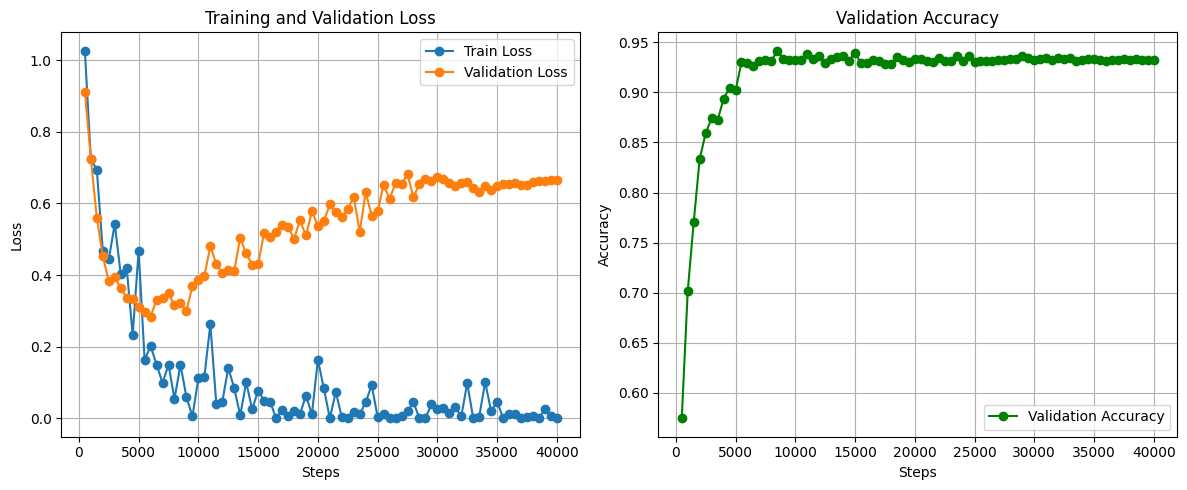

In [47]:
def plot_training_history(history):
 
    if not all(key in history for key in ['train_loss', 'steps', 'valid_loss', 'valid_accuracy']):
        raise ValueError("History dictionary must contain 'train_loss', 'steps', 'valid_loss', and 'valid_accuracy'.")

    steps = history['steps']
    train_loss = history['train_loss']
    valid_loss = history['valid_loss']
    valid_accuracy = history['valid_accuracy']

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, train_loss, label='Train Loss', marker='o')
    plt.plot(steps, valid_loss, label='Validation Loss', marker='o')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(steps, valid_accuracy, label='Validation Accuracy', color='green', marker='o')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [50]:
def load_checkpoint(path, vocab_size, device):
    
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model = Enc_Transformer(vocab_size, num_classes , model_args.dim_embed,
                     model_args.dim_model, model_args.dim_feedforward, model_args.num_layers,
                     model_args.dropout, model_args.max_len).to(device)
    model.load_state_dict(checkpoint["model_state_dict"])
    
    return model,checkpoint['history']
    
model_2, history_2= load_checkpoint('/kaggle/input/sentiment-model-12k-without-filterwords/sentiement_transformer_checkpoint.pt', 12000, training_args.device)

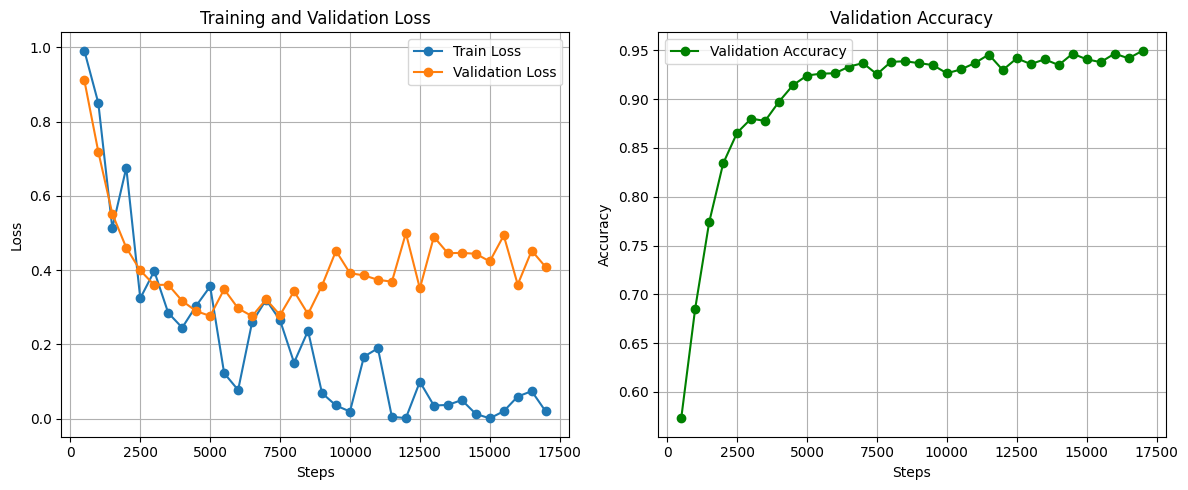

In [51]:
plot_training_history(history_2)

In [ ]:
def parse_function_test(text, filter_wordss:bool, language='english'):
    text = str(text)
    # Combined regular expression
    text = re.sub(pattern, replace_match, text)
    # for html tags
    html_tags_regex = re.compile(r'<[^>]+>',flags=re.IGNORECASE)
    
    # for stopwords
    nltk.download('stopwords', quiet=True)
    stopwords_regex = re.compile(r'\b(' + r'|'.join(filtered_stopwords) + r')\b\s*',flags=re.IGNORECASE)
   
    # for punctuations
    punctuations_regex = re.compile(r'[^a-z0-9\s]+',flags=re.IGNORECASE)
    # for words that contains numbers like f4g
    words_contains_numbers_regex = re.compile(r'\w*\d+\w*',flags=re.IGNORECASE)
    # for urls and links
    urls_regex = re.compile(r'https?:\/\/\s+|www\.\s+',flags=re.IGNORECASE)
   
    # Filter out words in the filter_words list
    filter_words_regex = re.compile(r'\b(' + r'|'.join(filter_words) + r')\b', flags=re.IGNORECASE)
    # Remove 1-2 character words
    trash_word_regex = re.compile(r'\b\w{1,2}\b') 
    
    # for multiple spaces and newlines
    multi_space_regex = re.compile(r'\n+|\s+')
    # Remove mentions
    mentions_regex = re.compile(r'@[a-zA-Z0-9_]+')
    # Remove special characters
    special_ch_regex = re.compile(r'\W') 
    # Remove after . 
    after_dot_regex = re.compile(r'\..*')
    
    text = emoji.demojize(text)  # Convert emojis to text
    text = html_tags_regex.sub(' ', text)
    # text = after_dot_regex.sub(' ', text)
    text = punctuations_regex.sub(' ', text)
    text = words_contains_numbers_regex.sub(' ', text)
    text = urls_regex.sub(' ', text)
    text = mentions_regex.sub(' ',text)
    text = special_ch_regex.sub(' ',text) 
    text = multi_space_regex.sub(' ', text)
    text = text.strip()

    # text = text.capitalize()
    # Apply POS tagging and filter tokens
    text = text.split()
    tagged_tokens = pos_tag(text)
    # print(tagged_tokens)
    filtered_words = [
       word.lower() for word, tag in tagged_tokens
        # if get_wordnet_pos(tag) in [wordnet.ADJ, wordnet.VERB, wordnet.ADV] # Filter only adjectives, verbs, and adverbs
        # or word in negation_words
    ]
    text = ' '.join(filtered_words)
    if filter_wordss:
        text = filter_words_regex.sub(' ',text)
    text = stopwords_regex.sub(' ', text)
    text = trash_word_regex.sub(' ',text)
    text = multi_space_regex.sub(' ', text)
    text = text.lower()
    text = text.strip()
    return text

In [63]:
def pred(model, tokenizer, text, filter_wordss: bool):
    model.eval()  # Set the model to evaluation mode
    parsed_text = parse_function_test(text, filter_wordss)
    cls_id = tokenizer.get_tokenId('<cls>')
    review_ids = [cls_id] + tokenizer(parsed_text)

    input_tensor = torch.tensor(review_ids).unsqueeze(0).to(training_args.device)

    with torch.inference_mode():  # More efficient than torch.no_grad()
        with torch.autocast(device_type=training_args.device, dtype=torch.bfloat16):
            logits = model(input_tensor, None, 0)

    target_id = torch.argmax(logits[0], dim=-1)
    print(logits)
    return id_classes[target_id.item()]


test = "this is a bad movie "
tokenizer_2 = Callable_tokenizer('/kaggle/input/sp-model-12k-without-filterwords/sp_model (10).model')

print(pred(model, tokenizer,test, True))
print(pred(model_2, tokenizer_2,test, False))


(tensor([[-5.7188, -3.2812,  8.3125]], device='cuda:0', dtype=torch.bfloat16), None)
Negative
(tensor([[-1.6875, -2.0781,  3.4375]], device='cuda:0', dtype=torch.bfloat16), None)
Negative


In [65]:
test = "amazing movie"
print(pred(model, tokenizer,test, True))
print(pred(model_2, tokenizer_2,test, False))

(tensor([[-2.8125,  7.7188, -1.7578]], device='cuda:0', dtype=torch.bfloat16), None)
Positive
(tensor([[-0.4375,  1.9844, -1.6406]], device='cuda:0', dtype=torch.bfloat16), None)
Positive


In [64]:
reviews, labels = df_prepro_reviews_test.iloc[100].reviews, df_prepro_reviews_test.iloc[100].labels

print("review: ",df_prepro_reviews_test.iloc[100].reviews, " label: ", df_prepro_reviews_test.iloc[100].labels)
print(pred(model, tokenizer,reviews, True))
print(pred(model_2, tokenizer_2,reviews, False))


review:  thinking face not sure data going frustrated kids using ammediately angry face app power hands high voltage download app store via thumbs  label:  0
(tensor([[12.5000, -4.3125, -1.9766]], device='cuda:0', dtype=torch.bfloat16), None)
Neutral
(tensor([[ 6.2812, -0.1289, -2.0781]], device='cuda:0', dtype=torch.bfloat16), None)
Neutral
